# Tile experiments

0 - lodged
1 - not lodged
2 - altro 

In [1]:
from tile_class import TileOperations
from classifier import predict, predict_batch
import pickle
import os

from tqdm import tqdm
from time import sleep

[[ 13.05310431   1.40279724  40.44634596]
 [-10.03970318  -0.09048928  40.09782063]
 [ -8.54070702 -23.1823944   39.71564193]
 [ 14.55210046 -21.68910788  40.06416725]]
[[ 17.09436557   1.2345787   40.58940095]
 [ -6.0565681   -0.22152077  40.34819949]
 [ -4.59471279 -23.36575512  39.75530096]
 [ 18.55622087 -21.90965566  39.99650242]]
[[  9.16997938   1.29371631  40.36966934]
 [-13.89680943  -0.076534    40.10029968]
 [-12.52172542 -23.14064564  39.6727601 ]
 [ 10.54506339 -21.77039533  39.94212976]]
[[18.78190876 15.51457617 39.59831874]
 [-4.18505613 14.55191869 39.88616528]
 [-3.22049671 -8.41629605 40.03373936]
 [19.74646818 -7.45363857 39.74589283]]
[[ 11.04722961  15.28486332  39.27120908]
 [-11.82423868  14.28544916  40.18611979]
 [-10.82889345  -8.60416569  40.06457972]
 [ 12.04257484  -7.60475153  39.14966901]]
[[15.17246216 15.3692484  39.27903002]
 [-7.72767735 14.36856843 40.19872309]
 [-6.72786795 -8.55003149 40.15696007]
 [16.17227156 -7.54935152 39.23726701]]
[[ 21.1694

In [2]:
tiles_dir = '/home/bota/Downloads/projtiles1/'
gps_csv = '/home/bota/Desktop/active_sensing/src/gpstiles.csv'
raw_imgs_dir = "/media/bota/BOTA/wheat/APPEZZAMENTO_PICCOLO/"

# Initialize TileOperations
tile_ops = TileOperations(tiles_dir, gps_csv, raw_imgs_dir)


# Test finding the closest image
tile_to_test = (20, 20)
closest_image_path, minimum_distance = tile_ops.find_closest_image(tile_to_test)

print(f"Selected tile image: {closest_image_path}")
print(f"Distance to tile center: {minimum_distance:.2f}")
# """

Selected tile image: DJI_20240607121633_0156_D_point19_tile20_20_crop.png
Distance to tile center: 8.44


In [3]:
pred_file = "prediction_on_tiles.pickle"
if os.path.isfile(pred_file):
    with open(pred_file, 'rb') as handle:
        predictions = pickle.load(handle)
else:

    predictions = {}
    batch_size = 100  # Define the maximum number of images per batch for predict_batch
    tiles = [(row, col) for row in range(3, 113) for col in range(13, 73)]
    batched_images = []
    batched_tiles = []
    pbar = tqdm(total=len(tiles))

    for tile_to_test in tiles:
        raw_imgs = tile_ops.get_rawimagepath(tile_to_test)
        to_predict = [tiles_dir + raw_img for raw_img in raw_imgs]
        
        if to_predict:
            batched_images.extend(to_predict)
            batched_tiles.extend([tile_to_test] * len(to_predict))
        
        # Process the batch if it reaches the batch_size or if it's the last tile
        if len(batched_images) >= batch_size or tile_to_test == tiles[-1]:
            batch_predictions = predict_batch(batched_images)  # Predict for the batched images
            
            # Assign predictions back to their respective tiles
            for tile, prediction in zip(batched_tiles, batch_predictions):
                if tile not in predictions:
                    predictions[tile] = []
                predictions[tile].append(prediction)
            
            # Clear the batch
            batched_images.clear()
            batched_tiles.clear()
        
        sleep(0.01)
        pbar.update(1)

    pbar.close()
    with open(pred_file, 'wb') as handle:
        pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [4]:
predictions[(45,45)]

[2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0]

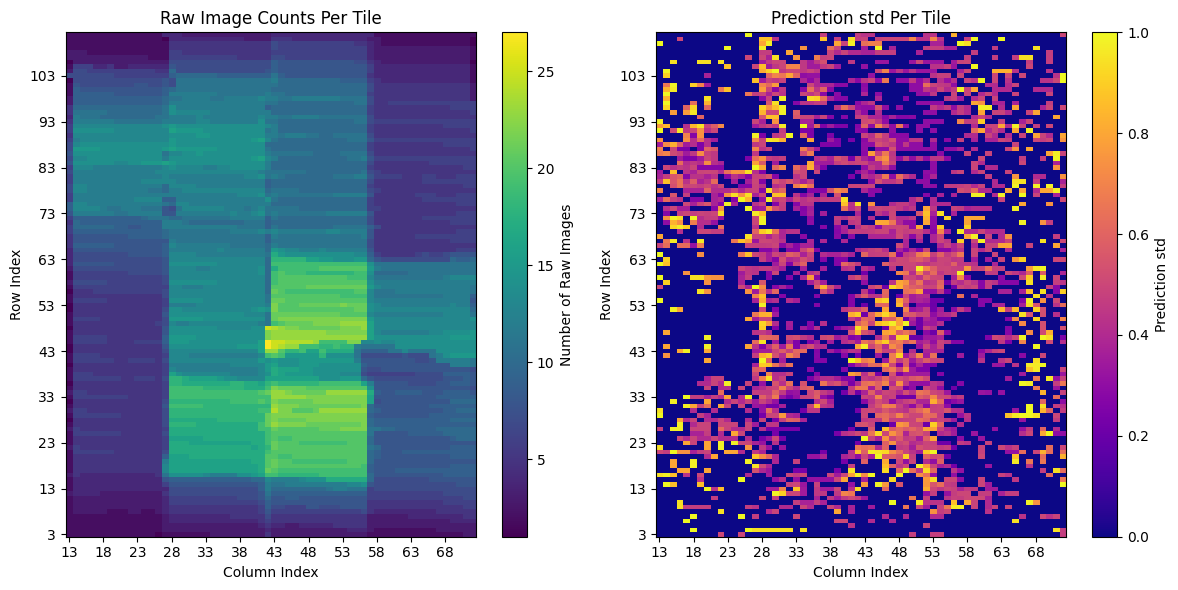

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the data
rows = range(3, 113)
cols = range(13, 73)
raw_img_counts = np.zeros((len(rows), len(cols)))
persistence = np.zeros((len(rows), len(cols)))
std = np.zeros((len(rows), len(cols)))
# Populate the raw_img_counts and persistence arrays
for (row, col), preds in predictions.items():
    row_idx = row - 3
    col_idx = col - 13
    raw_img_counts[row_idx, col_idx] = len(preds)
    if preds:  # Avoid division by zero
        persistence[row_idx, col_idx] = sum(preds) / len(preds)
        std[row_idx, col_idx] = np.std(preds)


# Plot 1: Raw image counts per tile
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(raw_img_counts, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Number of Raw Images')
plt.title('Raw Image Counts Per Tile')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

# Plot 2: Prediction persistence per tile
plt.subplot(1, 2, 2)
plt.imshow(std, aspect='auto', cmap='plasma', origin='lower')
plt.colorbar(label='Prediction std')
plt.title('Prediction std Per Tile')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

# Show the plots
plt.tight_layout()
plt.show()


In [6]:
def plot_fov_2d(fov_corners_all, centers):
    fig, ax = plt.subplots(figsize=(8, 8))

    for point in fov_corners_all:
        corners_ = order_fov_corners(point)
        ax.fill(corners_[:, 0], corners_[:, 1], alpha=0.2)
    ax.fill([-0.5,-0.5,0.5,0.5], [-0.5,0.5,0.5,-0.5],"r", alpha=0.5, )    
    ax.scatter([0], [0])
    for center in centers:
        ax.scatter(center[0], center[1])
    ax.set_xlabel("East")
    ax.set_ylabel("North")
    ax.set_aspect("equal", "box")
    ax.legend(handles=[])
    plt.show()

def order_fov_corners(corners):
    corners = np.array(corners)
    centroid = np.mean(corners[:, :2], axis=0)
    angles = np.arctan2(corners[:, 1] - centroid[1], corners[:, 0] - centroid[0])
    ordered_corners = corners[np.argsort(angles)]
    return ordered_corners

[[15.64170587 18.77225596 39.69328209]
 [-6.95950498 17.26991479 38.81971429]
 [-5.45534806 -5.34804407 38.80153952]
 [17.14586279 -3.8457029  39.67510732]]
[[ 21.02622961   4.30786332  39.27120908]
 [ -1.84523868   3.30844916  40.18611979]
 [ -0.84989345 -19.58116569  40.06457972]
 [ 22.02157484 -18.58175153  39.14966901]]
[[19.63679006 18.94900009 39.55842314]
 [-2.9752956  17.3670502  38.85333451]
 [-1.39659716 -5.25588731 38.98195537]
 [21.2154885  -3.67393741 39.68704399]]


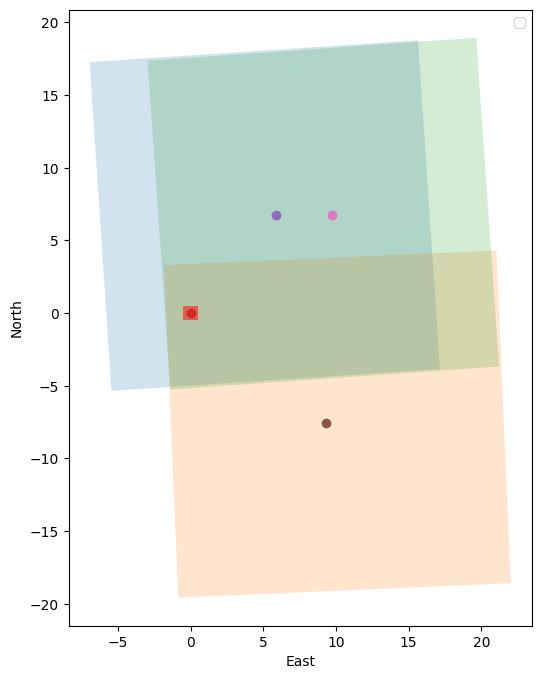

tile (3, 50)
corners [array([[15.64170587, 18.77225596, 39.69328209],
       [-6.95950498, 17.26991479, 38.81971429],
       [-5.45534806, -5.34804407, 38.80153952],
       [17.14586279, -3.8457029 , 39.67510732]]), array([[ 21.02622961,   4.30786332,  39.27120908],
       [ -1.84523868,   3.30844916,  40.18611979],
       [ -0.84989345, -19.58116569,  40.06457972],
       [ 22.02157484, -18.58175153,  39.14966901]]), array([[19.63679006, 18.94900009, 39.55842314],
       [-2.9752956 , 17.3670502 , 38.85333451],
       [-1.39659716, -5.25588731, 38.98195537],
       [21.2154885 , -3.67393741, 39.68704399]])]
[[15.27734217 21.32579602 39.61997476]
 [-7.37511842 19.81969049 38.54371845]
 [-5.8920245  -2.85401286 39.05778163]
 [16.76043608 -1.34790732 40.13403794]]
[[ 16.78590876   6.53257617  39.59831874]
 [ -6.18105613   5.56991869  39.88616528]
 [ -5.21649671 -17.39829605  40.03373936]
 [ 17.75046818 -16.43563857  39.74589283]]
[[ 16.03486614   6.57600229  42.06994187]
 [ -6.0938291   

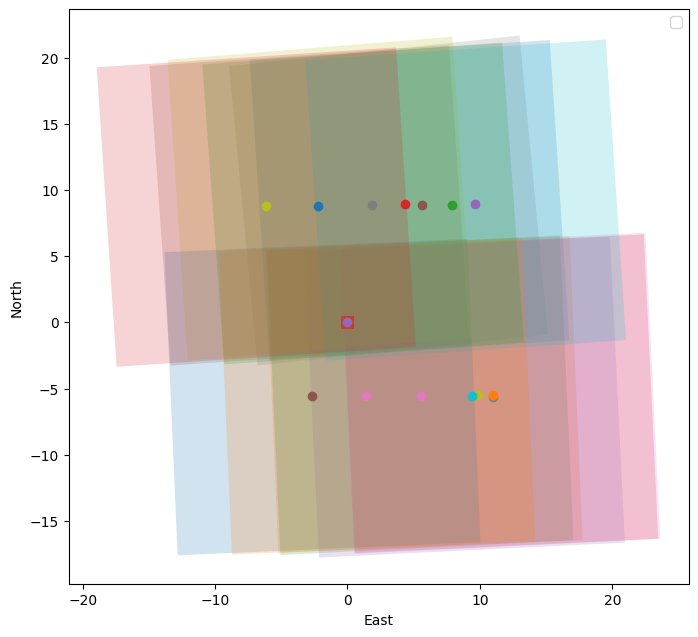

tile (15, 48)
corners [array([[15.27734217, 21.32579602, 39.61997476],
       [-7.37511842, 19.81969049, 38.54371845],
       [-5.8920245 , -2.85401286, 39.05778163],
       [16.76043608, -1.34790732, 40.13403794]]), array([[ 16.78590876,   6.53257617,  39.59831874],
       [ -6.18105613,   5.56991869,  39.88616528],
       [ -5.21649671, -17.39829605,  40.03373936],
       [ 17.75046818, -16.43563857,  39.74589283]]), array([[ 16.03486614,   6.57600229,  42.06994187],
       [ -6.0938291 ,   5.45337834,  35.73304609],
       [ -5.06393676, -17.56407989,  36.21431898],
       [ 17.06475847, -16.44145595,  42.55121476]]), array([[ 22.38266719,   6.64893097,  38.84696137],
       [ -0.52702781,   5.56516914,  40.69586395],
       [  0.56316785, -17.41867876,  40.7321195 ],
       [ 23.47286285, -16.33491693,  38.88321692]]), array([[ 19.81861132,   6.474753  ,  40.42842634],
       [ -3.27676134,   5.34474034,  39.7391941 ],
       [ -2.14477569, -17.76076477,  39.68969414],
       [ 20.

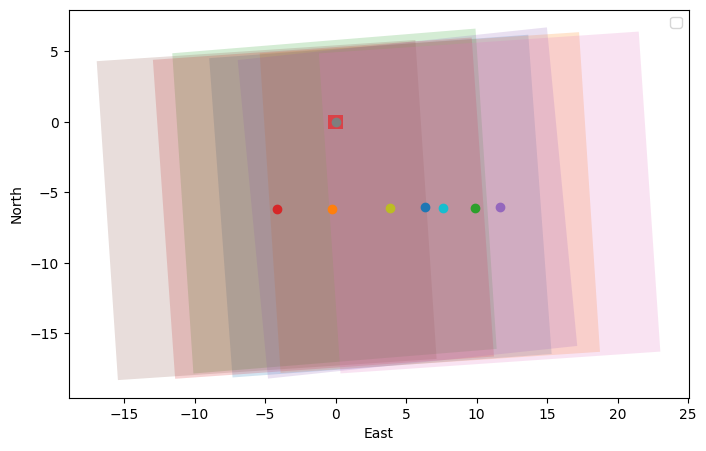

tile (13, 63)
corners [array([[ 13.67211735,   6.1750311 ,  39.60177128],
       [ -8.96183744,   4.51197612,  38.82261761],
       [ -7.30522805, -18.13484029,  39.03731082],
       [ 15.32872673, -16.47178531,  39.81646449]]), array([[ 17.27334217,   6.35679602,  39.61997476],
       [ -5.37911842,   4.85069049,  38.54371845],
       [ -3.8960245 , -17.82301286,  39.05778163],
       [ 18.75643608, -16.31690732,  40.13403794]]), array([[  9.92799425,   6.60881995,  41.55828991],
       [-11.58082175,   4.86084043,  34.23287775],
       [-10.08085847, -17.85618075,  35.24940124],
       [ 11.42795753, -16.10820124,  42.5748134 ]]), array([[  9.65779006,   5.97600009,  39.55842314],
       [-12.9542956 ,   4.3940502 ,  38.85333451],
       [-11.37559716, -18.22888731,  38.98195537],
       [ 11.2364885 , -16.64693741,  39.68704399]]), array([[ 14.99440088,   6.69564616,  40.99569607],
       [ -6.93944528,   4.37842924,  35.55760784],
       [ -4.79012166, -18.21576216,  36.51616327],


In [7]:
# tile_to_test = (45,45)

tile_to_test = (3,20)
# tile_to_test = (13,13)
for tile_to_test in [(3,50),(15,48),(13,63)]:
    fov_corners_all, centers = tile_ops.locate_wrt_tile(tile_to_test, ref_rel_alt=20)
    plot_fov_2d(fov_corners_all, centers)
    print(f"tile {tile_to_test}")
    # print(f"corners {fov_corners_all}")

In [8]:
fov_corners_all[0]

array([[ 13.67211735,   6.1750311 ,  39.60177128],
       [ -8.96183744,   4.51197612,  38.82261761],
       [ -7.30522805, -18.13484029,  39.03731082],
       [ 15.32872673, -16.47178531,  39.81646449]])

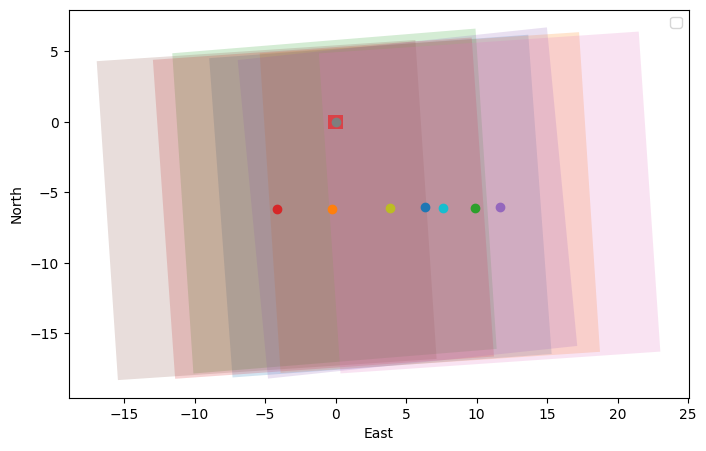

In [9]:
plot_fov_2d(fov_corners_all, centers)